# Paragraph causal relation detection: do they contain a causal relation or not

**Example**: '3-2: <span style="background-color: lightblue;">[concept Giving to the ECB the ultimate responsibility for supervision of banks in the euro area concept]</span> <span style="background-color: pink;">[explanation will decisively contribute to increase explanation]</span> <span style="background-color: lightblue;">[concept confidence between the banks concept]</span> <span style="background-color: pink;">[explanation and in this way increase explanation]</span> <span style="background-color: lightblue;">[concept the financial stability in the euro area concept]</span>. The euro area governments and the European institutions, including naturally the European Commission and the ECB, will do whatever is necessary to secure the financial stability of the euro area.\n'

## 1. Load data

This notebook expects three files in a subdirectory `csv`: `Map_Contents-20200726.csv`, `Speech_Contents-20210520.txt` and `Speeches-20210520.txt`. It will look for files with the speeches in the subdirectory `txt`. The names of the speech files are expected to start with the date followed by a space and the suname of the speaker (currently restricted to one word, see function `get_speech_id`).

If you are just interested in learning what the code is doing, you can skip all code blocks with the commands `import` (load libraries), `assert` (perform tests) and `def` (define functions), and examine the other code blocks.

In [1]:
cd ..

/Users/svenvanderburg/projects/SSIML2021


In [2]:
import os
from src.data.make_dataset import read_data_file

In [3]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'

In [4]:
map_contents = read_data_file("csv/Map_Contents-20200726.csv")

In [5]:
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")

In [6]:
speeches = read_data_file("csv/Speeches-20210520.txt")

## 2. Predict presence of causal relations in paragraphs

Steps:

1. store the paragraphs in the data structure X (data) after separating punctuation from words and replacing upper case by lower case
2. create a data structure y (labels) with True for paragraphs with causal relations and False for others
3. predict a label for each paragraph with a machine learning model generated from the other paragraphs
4. evaluate the results

The code in this task uses the packages `fasttext` (for machine learning) and `nltk` (for language processing) 

The task uses limited natural language processing to prepare the data for machine leaning:

1. tokenization: separate punctuation from words
2. conversion of upper case characters to lower case

Other interesting natural language preprocessing steps:

3. part-of-tagging
4. full parsing (Stanford parser)

In [7]:
from src.data.make_dataset import make_dataset

In [8]:
import fasttext
from langdetect import detect
from nltk.tokenize import word_tokenize
import numpy as np
import re
import sklearn
import pandas as pd
from termcolor import colored
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools

In [9]:
def make_train_test(X, y, test_index=0):
    train_list = []
    test_list = []
    index = 0
    for key in sorted(X.keys()):
        if index == test_index:
            test_list.append(f"__label__{str(y[key])} {X[key]}")
        else:
            train_list.append(f"__label__{str(y[key])} {X[key]}")
        index += 1
    return train_list, test_list

In [10]:
def make_train_file(file_name, train_list):
    data_file = open(file_name, "w")
    for line in train_list:
        print(line, file=data_file)
    data_file.close()

In [11]:
def decode_label(label):
    return re.sub("__label__", "", label) == "True"

In [12]:
def show_results(results):
    result_list = []
    for key in results:
        result_list.append({"paragraph": key})
        result_list[-1].update(results[key])
    return pd.DataFrame(result_list, index=[""]*len(result_list))

In [13]:
def count_y_values(y):
    values = {}
    for key in y:
        if y[key] not in values:
            values[y[key]] = 0
        values[y[key]] += 1
    table = []
    for key in values:
        table.append({"label": key, "count": values[key], "percentage": f"{round(100*values[key]/len(y), 1)}%"})
    return pd.DataFrame(table, index=[""]*len(table))

In [14]:
def squeal(text):
    clear_output(wait=True)
    print(text)

In [15]:
def make_fasttext_data(data_in):
    data_out = []
    for paragraph, label in data_in:
        data_out.append("__label__" + str(label) + " " + paragraph)
    return data_out

In [16]:
def run_experiments(X, y, wordNgrams=1, pretrainedVectors=""):
    y_pred = []
    y_true = [ y[key] for key in X if key in y]
    counter = 0
    data = np.array([ (X[key], y[key]) for key in X if key in y])
    for train_items, test_items in sklearn.model_selection.KFold(n_splits=10).split(X):
        train_data = make_fasttext_data(data[train_items])
        make_train_file("train_file.txt", train_data)
        model = fasttext.train_supervised("train_file.txt", dim=300, pretrainedVectors=pretrainedVectors, wordNgrams=wordNgrams)
        test_data = make_fasttext_data(data[test_items])
        predicted_labels = model.predict(test_data)
        y_pred.extend(predicted_labels[0])
        counter += 1
        squeal(f"Ran experiment {counter} of 10")
        
    y_pred = [decode_label(label[0]) for label in y_pred]
    return y_true, y_pred

The variable `X` in the next code block contains all the data (paragraphs) available for machine learning. The variable `y` contains all the associated labels, with values `True` or `False`.   

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
def evaluate_results(y_true, y_pred):
    precision, recall, fscore, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"Precision: {precision:0.3f}; recall: {recall:0.3f}; F1: {fscore:0.3f}")

In [19]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language de: 2015-01-19 Merkel Bundesregerung ann g.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file placeholder.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2009-12-14 Sarkoz

In [20]:
count_y_values(y)

,label,count,percentage
,True,660,73.6%
,False,237,26.4%


In [36]:
len(X)

878

In [37]:
len(y)

897

We run 10 experiments for 10 different splits. In each machine learning experiment, one part of the data is used as test data while all others are used for training a machine learning model to predict the labels of this part. 

In [33]:
y_true, y_pred = run_experiments(X, y, wordNgrams=1)
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.868; recall: 0.513; F1: 0.448


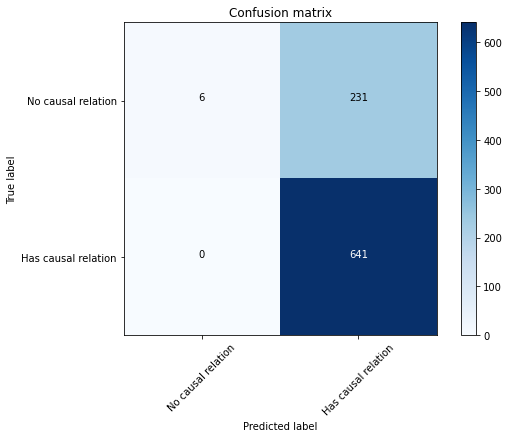

In [34]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

In [27]:
y_true, y_pred = run_experiments(X, y, wordNgrams=2)
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.365; recall: 0.500; F1: 0.422


/Users/svenvanderburg/opt/anaconda3/envs/ssi-ml-cognitive-mapping/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
y_true, y_pred = run_experiments(X, y, wordNgrams=3)
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.365; recall: 0.500; F1: 0.422


/Users/svenvanderburg/opt/anaconda3/envs/ssi-ml-cognitive-mapping/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_true, y_pred = run_experiments(X, y, wordNgrams=1, pretrainedVectors='wiki.en.vec')
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.669; recall: 0.641; F1: 0.650


In [30]:
y_true, y_pred = run_experiments(X, y, wordNgrams=2, pretrainedVectors='wiki.en.vec')
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.689; recall: 0.622; F1: 0.635


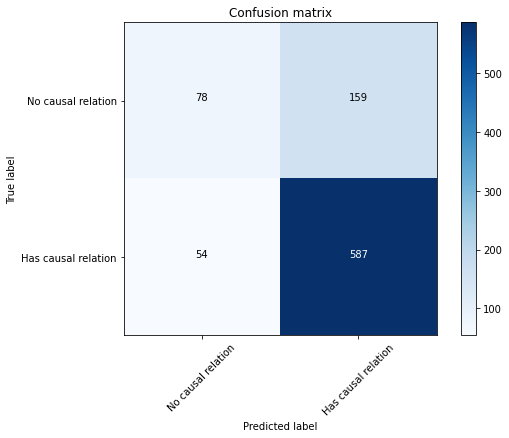

In [32]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)

In [35]:
y_true, y_pred = run_experiments(X, y, wordNgrams=3, pretrainedVectors='wiki.en.vec')
evaluate_results(y_true, y_pred)

Ran experiment 10 of 10
Precision: 0.683; recall: 0.587; F1: 0.590


| ngrams | language model | precision | recall | F1    |
| ------ | -------------- | --------- | ------ | ---- |
| 1      | no             | 0.868     | 0.513  | 0.448 |
| 2      | no             | 0.365     | 0.500  | 0.422 |
| 3      | no             | 0.365     | 0.500  | 0.422 |
| 1      | yes            | 0.669     | 0.641  | 0.650 |
| 2      | yes            | 0.689     | 0.622  | 0.635 |
| 3      | yes            | 0.683     | 0.587  | 0.590 |